In [ ]:
# Training a Neural Network with JAX and Optax

In [1]:
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from torchvision import datasets, transforms

##  Data Preparation

In [2]:
def load_mnist():
    transform = transforms.Compose([transforms.ToTensor(), lambda x: jnp.array(x.numpy().flatten(), dtype=jnp.float32)])
    
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    x_train = jnp.array([x for x, _ in train_dataset])
    y_train = jnp.array([y for _, y in train_dataset])
    x_test = jnp.array([x for x, _ in test_dataset])
    y_test = jnp.array([y for _, y in test_dataset])

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

100%|██████████| 9.91M/9.91M [00:00<00:00, 13.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 364kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]


## Basis Functions for Function Approximation

In [3]:
def polynomial_basis(x, degree=3):
    return jnp.array([x**i for i in range(1, degree+1)]).T

def gaussian_basis(x, centers, sigma=1.0):
    return jnp.exp(-((x - centers) ** 2) / (2 * sigma**2))

## Model Implementation

In [4]:
def init_mlp(layers):
    key = jax.random.PRNGKey(0)
    params = []
    for in_dim, out_dim in zip(layers[:-1], layers[1:]):
        key, subkey1, subkey2 = jax.random.split(key, 3)
        W = jax.random.normal(subkey1, (out_dim, in_dim)) * 0.01
        b = jax.random.normal(subkey2, (out_dim,)) * 0.01
        params.append((W, b))
    return params

def mlp_predict(params, x):
    for W, b in params[:-1]:
        x = jnp.tanh(jnp.dot(W, x) + b)
    W, b = params[-1]
    return jnp.dot(W, x) + b  # Output logits

##  Loss Function

In [5]:
def loss_function(params, x, y):
    y_pred = jax.vmap(mlp_predict, in_axes=(None, 0))(params, x)
    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(y_pred, y))

## Optimization with Optax

In [6]:
optimizers = {
    "sgd": optax.sgd(learning_rate=0.01),
    "adam": optax.adam(learning_rate=0.01),
    "rmsprop": optax.rmsprop(learning_rate=0.01)
}

def train(model_params, optimizer_name, epochs=10, batch_size=128):
    opt_init, opt_update = optimizers[optimizer_name]
    opt_state = opt_init(model_params)

    loss_history = []
    for epoch in range(epochs):
        batch_losses = []
        for i in tqdm(range(0, len(x_train), batch_size), desc=f"Epoch {epoch+1}/{epochs}"):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            grads = jax.grad(loss_function)(model_params, x_batch, y_batch)
            updates, opt_state = opt_update(grads, opt_state, model_params)
            model_params = optax.apply_updates(model_params, updates)

            batch_losses.append(loss_function(model_params, x_batch, y_batch))
        
        epoch_loss = jnp.mean(jnp.array(batch_losses))
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
    
    return loss_history, model_params

## Compare Optimizer Performance


In [7]:
def plot_optimizer_performance(histories):
    for optimizer, losses in histories.items():
        plt.plot(losses, label=optimizer)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Comparison of Optimizer Performance')
    plt.show()

## Training and Evaluation

Training with sgd optimizer...


Epoch 1/10: 100%|██████████| 469/469 [00:09<00:00, 47.88it/s]


Epoch 1, Loss: 2.3013


Epoch 2/10: 100%|██████████| 469/469 [00:07<00:00, 64.72it/s]


Epoch 2, Loss: 2.2988


Epoch 3/10: 100%|██████████| 469/469 [00:07<00:00, 64.67it/s]


Epoch 3, Loss: 2.2932


Epoch 4/10: 100%|██████████| 469/469 [00:07<00:00, 65.80it/s]


Epoch 4, Loss: 2.2558


Epoch 5/10: 100%|██████████| 469/469 [00:07<00:00, 65.90it/s]


Epoch 5, Loss: 1.9304


Epoch 6/10: 100%|██████████| 469/469 [00:07<00:00, 66.20it/s]


Epoch 6, Loss: 1.4454


Epoch 7/10: 100%|██████████| 469/469 [00:07<00:00, 64.93it/s]


Epoch 7, Loss: 1.1188


Epoch 8/10: 100%|██████████| 469/469 [00:07<00:00, 65.10it/s]


Epoch 8, Loss: 0.8967


Epoch 9/10: 100%|██████████| 469/469 [00:07<00:00, 65.36it/s]


Epoch 9, Loss: 0.7626


Epoch 10/10: 100%|██████████| 469/469 [00:07<00:00, 64.20it/s]


Epoch 10, Loss: 0.6632
Training with adam optimizer...


Epoch 1/10: 100%|██████████| 469/469 [00:09<00:00, 49.08it/s]


Epoch 1, Loss: 0.2535


Epoch 2/10: 100%|██████████| 469/469 [00:08<00:00, 53.17it/s]


Epoch 2, Loss: 0.1261


Epoch 3/10: 100%|██████████| 469/469 [00:08<00:00, 52.61it/s]


Epoch 3, Loss: 0.1046


Epoch 4/10: 100%|██████████| 469/469 [00:08<00:00, 53.11it/s]


Epoch 4, Loss: 0.0979


Epoch 5/10: 100%|██████████| 469/469 [00:08<00:00, 53.30it/s]


Epoch 5, Loss: 0.0922


Epoch 6/10: 100%|██████████| 469/469 [00:08<00:00, 52.75it/s]


Epoch 6, Loss: 0.0879


Epoch 7/10: 100%|██████████| 469/469 [00:09<00:00, 52.01it/s]


Epoch 7, Loss: 0.0840


Epoch 8/10: 100%|██████████| 469/469 [00:09<00:00, 51.94it/s]


Epoch 8, Loss: 0.0850


Epoch 9/10: 100%|██████████| 469/469 [00:08<00:00, 53.13it/s]


Epoch 9, Loss: 0.0805


Epoch 10/10: 100%|██████████| 469/469 [00:08<00:00, 53.21it/s]


Epoch 10, Loss: 0.0803
Training with rmsprop optimizer...


Epoch 1/10: 100%|██████████| 469/469 [00:08<00:00, 57.21it/s]


Epoch 1, Loss: 0.2120


Epoch 2/10: 100%|██████████| 469/469 [00:07<00:00, 58.86it/s]


Epoch 2, Loss: 0.0439


Epoch 3/10: 100%|██████████| 469/469 [00:08<00:00, 57.94it/s]


Epoch 3, Loss: 0.0284


Epoch 4/10: 100%|██████████| 469/469 [00:08<00:00, 56.37it/s]


Epoch 4, Loss: 0.0236


Epoch 5/10: 100%|██████████| 469/469 [00:08<00:00, 58.26it/s]


Epoch 5, Loss: 0.0212


Epoch 6/10: 100%|██████████| 469/469 [00:08<00:00, 57.90it/s]


Epoch 6, Loss: 0.0192


Epoch 7/10: 100%|██████████| 469/469 [00:07<00:00, 59.29it/s]


Epoch 7, Loss: 0.0167


Epoch 8/10: 100%|██████████| 469/469 [00:07<00:00, 58.80it/s]


Epoch 8, Loss: 0.0152


Epoch 9/10: 100%|██████████| 469/469 [00:08<00:00, 58.35it/s]


Epoch 9, Loss: 0.0152


Epoch 10/10: 100%|██████████| 469/469 [00:08<00:00, 57.64it/s]


Epoch 10, Loss: 0.0144


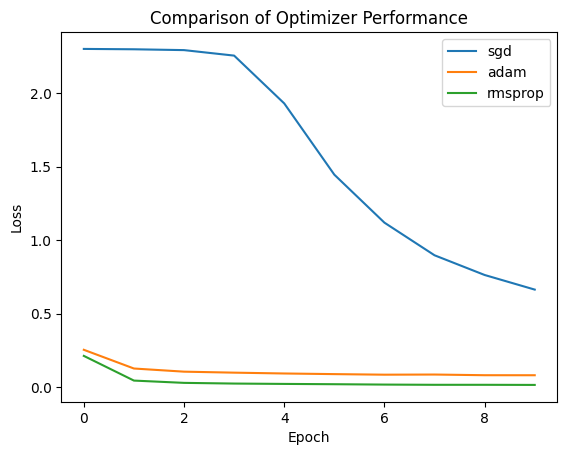

In [8]:
layers = [784, 128, 64, 10]
histories = {}
saved_models = {}

for optimizer_name in optimizers.keys():
    print(f"Training with {optimizer_name} optimizer...")
    model_params = init_mlp(layers)
    histories[optimizer_name], trained_model = train(model_params, optimizer_name)
    
    # Save trained model
    with open(f"trained_model_{optimizer_name}.pkl", "wb") as f:
        pickle.dump(trained_model, f)
    saved_models[optimizer_name] = trained_model

plot_optimizer_performance(histories)

## Load and Test Saved Model


In [9]:
def load_model(optimizer_name):
    with open(f"trained_model_{optimizer_name}.pkl", "rb") as f:
        return pickle.load(f)

In [10]:
# Example usage
loaded_model = load_model("adam")
y_pred = jax.vmap(mlp_predict, in_axes=(None, 0))(loaded_model, x_test[:10])
print("Predictions for first 10 test samples:", jnp.argmax(y_pred, axis=1))

Predictions for first 10 test samples: [7 2 1 0 4 1 4 3 5 9]
